In [1]:
DIR = r"/home/cz/Dropbox/Summer RA Model EP/Parameters/"

import os
for t in os.listdir(DIR):
    print('-', t)

- ep_params.csv
- ep_amenities.csv
- ep_Z.csv
- ep_phi.csv
- ep_tau.csv
- ep_Q_A.csv
- ep_vA.csv
- matlab.mat
- ep_Capital.csv
- ep_Q_NA.csv
- ep_wage1880.csv
- ep_skill1880.csv


## Reading the parameters

In [2]:
class Params(object):
    pass

param = Params()
with open(os.path.join(DIR, 'ep_params.csv')) as f:
    lines = f.readlines()
    values = lines[0].split(',')
    names = lines[2].replace('[','').replace(']','').strip().split(' ')
    
    if len(values) != len(names):
        print('not sure how to read this...')
        print(lines)
        
    print('Found {} parameters'.format(len(values)))    
    for k,v in zip(names, values):
        print('{} = {}'.format(k,v))
        setattr(param, k.split('.')[1], float(v))

Found 13 parameters
param.beta = 0.28818
param.q = 0.67565
param.mu = 3.4112
param.zeta = 1.62
param.alpha = 0.05
param.sigma = 4
param.psi = 0.76551
param.delta = 0.91803
param.eta = 0.35
param.gamma = 0.35055
param.nu = 0.0187
param.kappa = 0.42
param.r = 2.8866



In [3]:
# so now we can do
param.kappa

0.42

## Reading the rest of the files

We have:
- ep_params.csv
- ep_amenities.csv
    - 645 by 5 matrix
    - first column is NaN
- ep_Z.csv
    - 5 by 2 matrix
- ep_phi.csv
    - 4 by 1 matrix
- ep_tau.csv
    - 645 by 645 matrix
- ep_Q_A.csv
    - 645 by 5 matrix
- ep_vA.csv
    - 5 by 1 matrix
- matlab.mat
- ep_Capital.csv
    - 5 by 1 matrix
- ep_Q_NA.csv
    - 645 by 5 matrix
- ep_wage1880.csv
    - 645 by 2 matrix
- ep_skill1880.csv
    - 645 by 2 matrix

In [404]:
import pandas as pd

def read(name):
    myfile = os.path.join(DIR, 'ep_{}.csv'.format(name))
    df=pd.read_csv(myfile, header=None)
    return df

def read_matrix(name):
    df = read(name)
    mat = df.values.T
    print("{}: {}".format(name.rjust(10), mat.shape))
    return mat

skills, wages = read_matrix("skill1880"), read_matrix("wage1880")
Q_A, Q_NA = read_matrix("Q_A"), read_matrix("Q_NA")

Z = read_matrix("Z")
vA = read_matrix("vA")
Capital = read_matrix("Capital")
phi = read_matrix("phi")

tau = read_matrix("tau")
amenities = read_matrix("amenities")

 skill1880: (2, 645)
  wage1880: (2, 645)
       Q_A: (5, 645)
      Q_NA: (5, 645)
         Z: (2, 5)
        vA: (1, 5)
   Capital: (1, 5)
       phi: (1, 4)
       tau: (645, 645)
 amenities: (5, 645)


### IMPORTANT: A note on mat indexing

In order to vectorize computations, we need to obey the rules of Numpy broadcasting, i.e. this means putting our axes in order. Doing this involves careful checking to see if the matrices end up being what we expect.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
A, NA = 0,1

Q = np.stack((Q_A, Q_NA)).transpose((1,0,2))
Q.shape

(5, 2, 645)

In [149]:
Q[:,A,:] == Q_A

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

The reason we're going to do this axis ordering is so that we can get Numpy broadcasting to work well. Numpy, I think unlike Matlab, does broadcasting for the trailing indices of the matrix.

So: keep in mind that Q is indexed like [t, s, r] now

# Step by step

First, we want to compute the $\pi$ from the wages

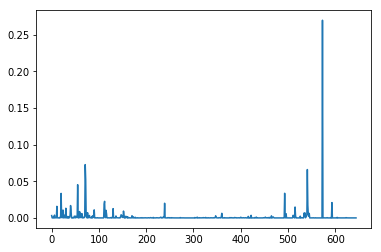

In [193]:
t=0

def computePi(wages):
    sigma = param.sigma
    pi = Q[t]**(sigma-1) * wages**((1-param.alpha)*(1-sigma)) # 2,645
    sums = np.sum(pi, axis=1)**(1/(1-sigma)) # 2,
    
    # so we have to do them separately
    pi[0] = pi[0]/sums[0]
    pi[1] = pi[1]/sums[1]
    
    return pi   
    
p = computePi(wages)
plt.plot(p[A])

Next, we're going to read $L_{rt}$ and $\lambda_{rt}$ from the file

In [75]:
overall_lamda = np.sum(skills, axis=1) # this is \lambda overall
overall_lamda

array([0.7046579 , 0.29534209])

In [191]:
Lrt = np.sum(skills, axis=0)
Lrt.shape, np.sum(Lrt) # L has to sum to 1, if we're goodd

((645,), 0.999999993419246)

In [350]:
lam_rt = (skills/Lrt)[0]
lam_rt.shape

(645,)

Finally, we're going to compute $\Theta$ from the wages:

$$
\Theta^h_{rt} = (\Psi^h_A w_{rAt}^\zeta + \Psi^h_{NA} w_{rNAt}^\zeta)^{1/\zeta}
$$
... (and similarly for the low-skill group)

In [158]:
L,H = 0,1

Psi = np.array([[1,1],
                [1,1.6]])

assert Psi[H, A] == 1
assert Psi[H, NA] == 1.6

In [159]:
wages.shape

(2, 645)

In [163]:
Psi[H].shape

(2,)

In [172]:
# for region 0
region = 0
assert sum(wages[:,region] * Psi[H]) == np.matmul(Psi[H], wages)[region]

In [1]:
# so this is the right thing to do
Theta = np.matmul(Psi, wages**(param.zeta)) ** (1/param.zeta)
Theta_l = Theta[L]
Theta_h = Theta[H]

plt.scatter((wages[A]**param.zeta+1.6*wages[NA]**param.zeta)**(1/param.zeta), Theta_h)

NameError: name 'np' is not defined

## Labor market clearing

In [126]:
foo = (wages/Theta_h).transpose((2,0,1))
sh = foo**param.zeta * Psi[H]
sh = sh.transpose((1,2,0))
sh.shape

(1, 2, 645)

In [127]:
foo = (wages/Theta_l).transpose((2,0,1))
sl = foo**param.zeta * Psi[L]
sl = sl.transpose((1,2,0))
sl.shape

(1, 2, 645)

In [129]:
np.sum(sl, axis=S)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

## Building the wage loop

In [182]:
# these are fixed
const_lamda, sums, skill_shares = computeLrt(skills)
    
# ----------- test 1 iteration of the loop ----------------
# normalize wages BY THE PRICE OF THE AGRICULTURAL GOOD

wages = priceNormalize(wages)

# compute the update
pi = computePi(wages) # (1 by 2 by 645)
Theta_h, Theta_l = computeTheta(wages) # (645,)
GDP = computeGDP(skills, wages)
GDP

#  labor market clearing conditions

# A
s_hA = Psi[H,A] * (wages[t,A] / Theta_h)**(param.zeta)
s_lA = Psi[L,A] * (wages[t,A] / Theta_l)**(param.zeta)
x_A = myGamma(param.zeta) * (skills[t,H] * s_hA + skills[t,L] * s_lA)

# NA
s_hNA = Psi[H,NA] * (wages[t,NA] / Theta_h)**(param.zeta)
s_lNA = Psi[L,NA] * (wages[t,NA] / Theta_l)**(param.zeta)
x_NA = myGamma(param.zeta) * (skills[t,H] * s_hNA + skills[t,L] * s_lNA)

s_hA + s_hNA # sums to 1, yup
1

1

In [183]:
def test_loopy(skills, wages, log=True):
    
    lr = 0.1
    labels = ['Before']
    
    # these are fixed
    const_lamda, sums, skill_shares = computeLrt(skills)
    
    for i in range(250):
        # normalize wages BY THE PRICE OF THE AGRICULTURAL GOOD

        wages = priceNormalize(wages)

        # compute the update
        pi = computePi(wages) # (1 by 2 by 645)
        Theta_h, Theta_l = computeTheta(wages) # (645,)
        GDP = computeGDP(skills, wages)
        revenue = (1-param.alpha) * pi * vAt * GDP
        GDP

        #  labor market clearing conditions

        # A
        s_hA = Psi[H,A] * (wages[t,A] / Theta_h)**(param.zeta)
        s_lA = Psi[L,A] * (wages[t,A] / Theta_l)**(param.zeta)
        x_A = myGamma(param.zeta) * (skills[t,H] * s_hA + skills[t,L] * s_lA)

        # NA
        s_hNA = Psi[H,NA] * (wages[t,NA] / Theta_h)**(param.zeta)
        s_lNA = Psi[L,NA] * (wages[t,NA] / Theta_l)**(param.zeta)
        x_NA = myGamma(param.zeta) * (skills[t,H] * s_hNA + skills[t,L] * s_lNA)
        
        newWages = revenue / np.vstack([x_A, x_NA])
        
        loss = np.sum(np.abs(newWages - wages))
        wages = lr * newWages + (1-lr) * wages
        
    for i in range(10):
        # normalize wages BY THE PRICE OF THE AGRICULTURAL GOOD
        
        
        print('Before normalize:', np.sum(wages))
        wages = priceNormalize(wages)
        
        print('After normalize:', np.sum(wages))

        # compute the update
        pi = computePi(wages) # (1 by 2 by 645)
        Theta_h, Theta_l = computeTheta(wages) # (645,)
        GDP = computeGDP(skills, wages)
        revenue = (1-param.alpha) * pi * vAt * GDP
        GDP

        #  labor market clearing conditions

        # A
        s_hA = Psi[H,A] * (wages[t,A] / Theta_h)**(param.zeta)
        s_lA = Psi[L,A] * (wages[t,A] / Theta_l)**(param.zeta)
        x_A = myGamma(param.zeta) * (skills[t,H] * s_hA + skills[t,L] * s_lA)

        # NA
        s_hNA = Psi[H,NA] * (wages[t,NA] / Theta_h)**(param.zeta)
        s_lNA = Psi[L,NA] * (wages[t,NA] / Theta_l)**(param.zeta)
        x_NA = myGamma(param.zeta) * (skills[t,H] * s_hNA + skills[t,L] * s_lNA)
        
        newWages = revenue / np.vstack([x_A, x_NA])
        newWages = priceNormalize(newWages)
        
        loss = np.sum(np.abs(newWages - wages))
        wages = lr * newWages + (1-lr) * wages
        print('------update:', np.sum(wages))
        
        if loss < 1e-7:
            print('w-- #{}: {}'.format(i, loss))
            drawLog(wages)
            labels.append('iteration {}'.format(i))
            break

        if i % 30 == 0:
            print('w-- #{}: {}'.format(i, loss))
            drawLog(wages)
            labels.append('iteration {}'.format(i))
            
    
    plt.legend(labels)
    return wages

Before normalize: 38.80996415710386
After normalize: 37.10401251890202
------update: 37.104012518902024
w-- #0: 1.557174528210581e-14


Text(0,0.5,'Non-Agricultural wages')

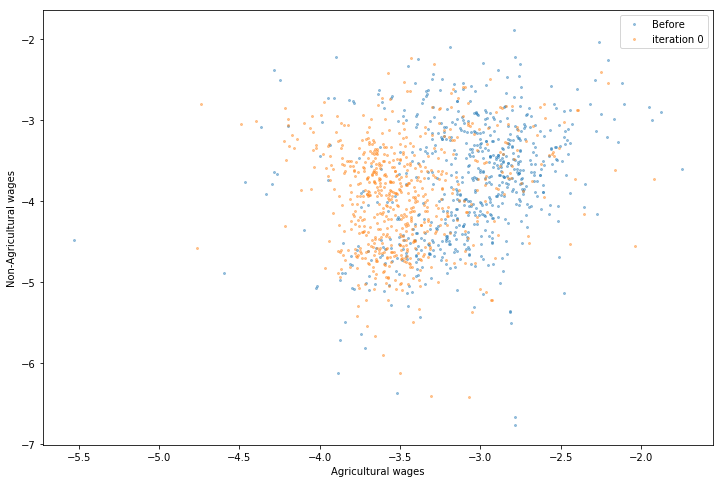

In [184]:
wages = readWages()
plt.figure(figsize=(12,8))
drawLog(priceNormalize(wages))
newWages = test_loopy(skills, wages)
plt.xlabel('Agricultural wages'); plt.ylabel('Non-Agricultural wages')

ISSUE: wages is different after normalization... every time

## updating people

We have to be careful because tau.csv is a region x region matrix. this means that if we took the transpose... well, you get the idea

In [205]:
interest_rate = param.r/100

def psi(r):
    n = param.eta
    ret = 1 + (param.beta**(1/(1-n))) * ((1+r)**(n/(1-n)))
    return 1/ret

psi_con = psi(interest_rate)
psi_con

0.8697539002059759

In [234]:
n = param.eta

constant1 = myGamma(n/param.zeta)/n
constant2 = psi_con**(n-1)

# since the interest rate is a constant, we can take psi(r_{t+1}) to be a constant too
W_rt = constant1*constant2*(myGamma(param.zeta)*Theta_h)**n + amenities[1] # amenities in 1910

In [233]:
np.all(W_rt - tau[0] == (W_rt - tau)[0]) # W_rt lays across the rows of MC_jr. is this what we want?

True

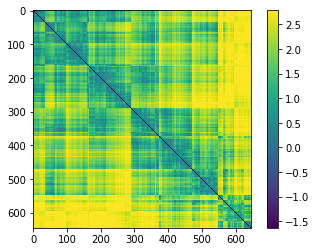

In [338]:
plt.imshow(tau)
plt.colorbar();plt.show()

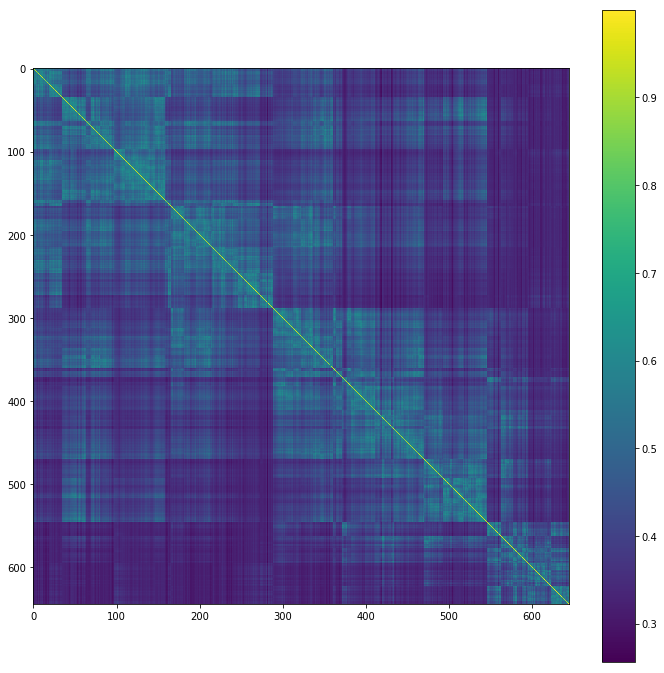

In [340]:
rho = np.exp(1/param.kappa * (W_rt - tau))
rho = rho / np.sum(rho, axis=1)

plt.figure(figsize=(12,12))
plt.imshow(rho**0.1)# the reason I have to do this is because it appears that 
# most of the values are really low, 
# and a few capture almost 99% of the weights. specifically, most people stay put.
plt.colorbar()
plt.show()

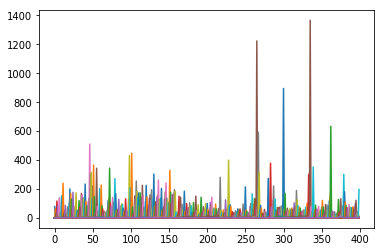

In [325]:
plt.plot(rho[:400])
plt.show()

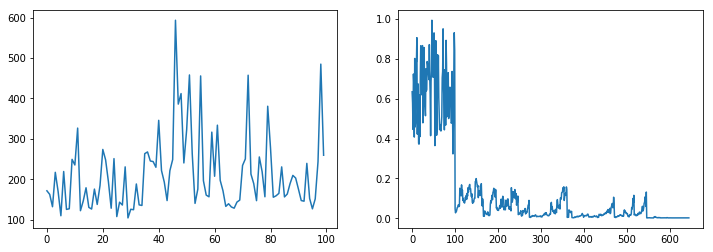

In [317]:
# the problem with this is that we can't normalize properly, even after we divide by the sum
rho = np.exp(1/param.kappa * (W_rt - tau))
sums = np.sum(rho, axis=1)
rho_normalized = rho[:,:100]/sums[:100]
sums_normalzied = np.sum(rho_normalized, axis=1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(sums[:100])

plt.subplot(1,2,2)
plt.plot(sums_normalzied)

# How does it work?

It's a 2-loop system. You start with a guess for $L$ - where the people are going to be in 1910. (how you know this is another story. See, the wages in 1910 probably determine where people moved to, but we don't know.)

1. Guess some wages. Compute $\pi$. Use (3) and (4), with $L_{rt}$ fixed, to update the guess on the wages until $w$ and $\pi$ converge.
2. Calculate the moving probabilities $\rho$ using (6). This $\rho$ depends on $W_{rt}$, which is a function of the wages in 1910. Update $L$ using the population in 1880 and this $\rho$ which we basically guessed. Now, armed with an improved estimate of $L$, go back to **step 1** to guess better 1910 wages.
3. Repeat steps **1** and **2** until both $L$ and $w$ converge.


### Here's a function we see a lot! $\Gamma$

In [194]:
from scipy.special import gamma
from scipy.stats import invweibull as frechet

assert gamma(5) == 24 # gamma(n+1) = n!

def myGamma(zeta):
    return gamma(1-1/zeta)

myGamma(param.zeta)

2.3211529336709016

### testing out the Frechet distribution

In [11]:
frechet.mean(param.zeta) # this matches up!

2.3211529336709016

## solution to the household problem (proposition 1)

The optimal level of expenditure of the young (and old) generation, given the interest rate and the specification of preferences in equation (4) has the following form:
$$
\begin{align}
e^Y_t (y)        & = \Psi( r_{t+1} ) y \\
e^O_t (y)        & = (1+r_{t+1}) ( 1 - \Psi( r_{t+1} )) y \\
U_{rt}^i = U_t(y) &= \frac{1}{\eta} \Psi( r_{t+1} ) ^{\eta -1} y^\eta + A_{t,t+1}
\end{align}
$$


where 

$$
\Psi( r_{t+1} ) = ( 1+\beta^{\frac{1}{1-n}} (1+r_{t+1}) ^{\frac{\eta}{1-\eta}} )^{-1}
$$

In [73]:

# create some fake prices
ns = 2
nt = 5
p = np.abs(np.random.randn(ns,nt))

# handy constants? be careful not to name anything else A or NA!
A,NA = 0,1

# ----- helper functi0ns -----
def consumption(r_t, n=0.1, beta=0.5):
    k = 1.0 + beta**(1/(1-n)) + (1+r_t)**(n/(1-n))
    return 1.0/k

def AA(t):
    pAt, pNAt = p[A,t], p[NA,t]
    pAt_1, pNAt_1 = p[A,t+1], p[NA, t+1]

    eta = param.eta
    y = param.gamma
    beta = param.beta
    v = param.nu

    stuff = (pAt/pNAt)**y + beta*(pAt_1*(1/pNAt_1)**y)
    return -v/y * stuff + (1+beta)*(v/y - 1/eta)

def expenditure(y):
    t = 0
    r_t = 0.93
    eta = param.eta
    
    e_Y = consumption(r_t) * y
    e_O = (1+r_t) * (1-consumption(r_t)) * y
    utility = 1/eta * consumption(r_t)**(eta-1) * y**eta + AA(t)
    
    print(consumption(r_t))
    return e_Y, e_O, utility

expenditure(np.array([2,3,4,3]))

0.39389772874118284


(array([0.78779546, 1.18169319, 1.57559091, 1.18169319]),
 array([2.33955477, 3.50933215, 4.67910953, 3.50933215]),
 array([3.01745055, 4.03485836, 4.84947579, 4.03485836]))

## Proposition 2: how do people move given the static equilibrium wages and exogenous emenities?

In [164]:
np.sum(skills, axis=0) # L, H

array([0.7046579 , 0.29534209])

In [157]:
# labor market clearing
nregions = 645

L = np.abs(np.random.randn(nregions))


s = phi(h,s) * wages/theta
weighted_wages_A = skills[:,0] * s * 
L*myGamma(param.zeta)* weighted_wages_A

array([4.72240465e-01, 1.10713590e+00, 3.01870647e-01, 7.68103625e-01,
       1.78727416e-01, 1.65019401e+00, 1.50062303e+00, 2.85061724e+00,
       1.40780016e+00, 2.14580958e-01, 1.43194401e+00, 8.88353677e-01,
       1.32679700e+00, 1.97633258e+00, 1.23867082e+00, 3.38871557e-01,
       1.27463980e+00, 2.17726333e+00, 1.52533139e+00, 1.35788465e-02,
       1.57194097e+00, 5.11189200e-01, 6.60997858e-01, 4.90508682e-01,
       6.55112657e-01, 1.13760606e+00, 1.43227801e+00, 1.62539861e-02,
       2.16508109e-01, 3.69167571e-01, 1.07251045e+00, 2.14021415e-01,
       1.99699488e-01, 7.68979929e-01, 7.07650578e-01, 7.59754449e-01,
       5.70585824e-01, 6.20313129e-01, 6.56184469e-01, 2.92692759e-01,
       6.96506425e-02, 1.56095978e+00, 5.99015445e-01, 8.53304593e-01,
       1.96766139e+00, 4.33152786e-01, 1.44479631e-01, 8.66774440e-02,
       7.23888067e-01, 7.91661286e-01, 1.42700505e+00, 1.08902428e+00,
       2.71102843e-01, 1.46235230e-01, 1.06313981e+00, 2.90463111e-01,
      

shape of wages: (645,)
moving costs: (645, 645)
normalized row sum: 0.9999999999999993


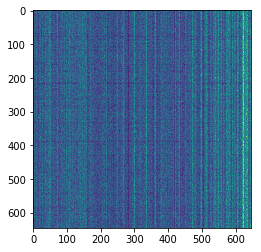

In [156]:
# set these up for now
interest_rates = np.array([0.01, 0.01, 0.01, 0.01, 0.01])

def W(wages, t=1):
    """
    relative life-time value at each location at time t
    """
    r_t1 = interest_rates[t+1]
    Art = amenities[:,t] # for all the r's
    
    constant = myGamma(param.eta/param.zeta)/param.eta
    wrt = constant * consumption(r_t1)**(param.eta - 1) * wages**(param.eta) + Art
    return wrt

# high skill
def moving_probabilities(wrt):    
#     MC = np.zeros((645, 645))
    MC = np.random.randn(645, 645)
    
    print('shape of wages:', wrt.shape)
    print('moving costs:', MC.shape)
    
    # note how it broadcasts wrt to be the same size as MC!
    pjrt = np.exp(1/param.kappa * wrt - MC)
    
    row_sums = pjrt.sum(axis=1)
    pjrt = pjrt / row_sums[:, np.newaxis]
    
#     print('difference btw rows:', sum(pjrt[1,:] - pjrt[2,:]))
    print('normalized row sum:', sum(pjrt[1,:]))
    
    return pjrt

# since each ROW is the same, we see COLUMNS
plt.imshow(moving_probabilities(W(wages[:,0]))**0.1)

In [ ]:
# mobility flows

In [84]:
def vA(t, wages, previousWages):
    """
    computes the share of agriculture in aggregate spending
    """
    r_t, r_t1 = interest_rates[t], interest_rates[t+1]
    
    young = consumption(r_t1) * myGamma(param.zeta) * wages
    old = (1+r_t) * (1-consumption(r_t)) * myGamma(param.zeta) * previousWages
    vTwiddle = param.nu * myGamma(param.zeta/(1-param.nu))/(myGamma(param.zeta)**(1-param.nu))
    
vA(1, wages=wages[:,1], previousWages=wages[:,0])

In [86]:
def getWages(s):
    return wages[:,s]

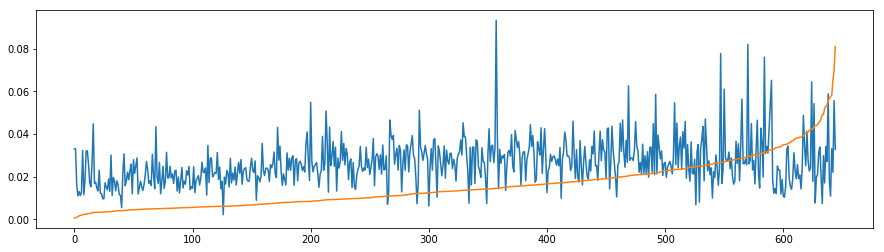

In [113]:
plt.figure(figsize=(15,4))
plt.plot(sorted(zip(getWages(A), getWages(NA)), key=lambda x: x[1])) 
# perhaps the second column is A wages, since I'd expect them to be lower?

# Extra

### what does the consumption share function look like?

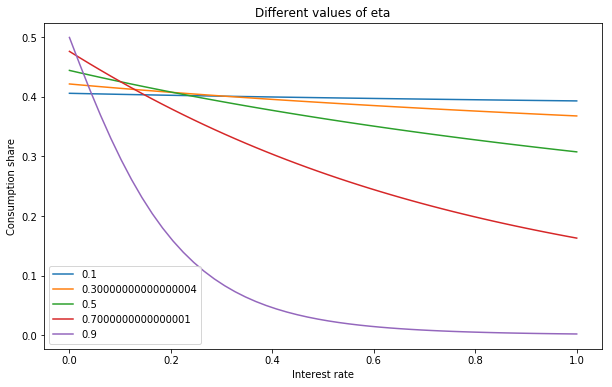

In [105]:
class Var:
    def __init__(self, name, values):
        self.name = name
        self.values = values
        
# var = Var("beta", np.linspace(0.1, 0.9, num=5))
var = Var("eta", np.linspace(0.1, 0.9, num=5))

plt.figure(figsize=(10,6))
x = np.linspace(0,1)
for b in var.values:
#     plt.plot(x, consumption(x, beta=b))
    plt.plot(x, consumption(x, n=b))
plt.legend(var.values)
plt.xlabel("Interest rate")
plt.ylabel("Consumption share")
plt.title("Different values of {}".format(var.name))
plt.show()

* $\beta$ moves the curve up and down.
* $\eta$ controls how quickly it drops. If $\eta$  is close to 0, this means that the consumer is not very sensitive to the interest rate... the demand is homothetic

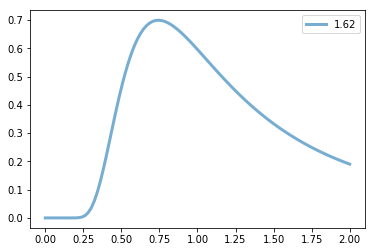

In [10]:
fig, ax = plt.subplots(1, 1)

x = np.linspace(0, 2, 100)
cs = [param.zeta]
for c in cs:
    ax.plot(x, frechet.pdf(x, c),
       lw=3, alpha=0.6, label='invweibull pdf')
plt.legend(cs)